In [97]:
import pandas as pd
import numpy as np
import talib as ta

import seaborn as sns
import matplotlib.pyplot as plt

PATH_READ = '123181_test_raw.csv'
PATH_READ_STOCK = '301085_test_raw.csv'

PATH_WRITE = '123181_test_withF.csv'
# df = pd.read_csv(PATH_READ, index_col='Timestamp')
df = pd.read_csv(PATH_READ)
df_stock = pd.read_csv(PATH_READ_STOCK)

df = df.drop(['InstrumentID','TradingDay','PreClosePrice',], axis=1)

print(df.columns)

Index(['Timestamp', 'Open', 'High', 'Low', 'Volume', 'Turnover', 'Close'], dtype='object')


In [98]:
def log_Return (df,type,period):
    return np.log(df[type] / df[type].shift(period))

In [99]:
def BBands (df, type, period):
    close_prices = np.array(df[type])

    upper_band, middle_band, lower_band = ta.BBANDS(close_prices, timeperiod=period)

    return upper_band, middle_band, lower_band

In [100]:
def MACD(df, column, fastPeriod, slowPeriod, signalPeriod):
    close = np.array(df[column])
    macd, signal, hist = ta.MACD(close, fastperiod=fastPeriod, slowperiod=slowPeriod, signalperiod=signalPeriod)
    return macd

In [101]:
def RSI (df, type, period):
    close = np.array(df[type])
    return ta.RSI(close, timeperiod = period)

In [102]:
def SAR (df, acc, max):
    high = np.array(df['High'])
    low = np.array(df['Low'])
    
    return ta.SAR(high, low, acceleration = acc, maximum = max)

In [103]:
def target(df, column, period):
    if period == 1:
        return (df[column].shift(-1) - df[column])/df[column]
    if period > 1:
        return (df[column].rolling(window=period).mean().shift(-1 * period) - df[column]) / df[column]

Custom BBands indicator

[高 - 中轨] / 布林带上段宽度

[低 - 中轨] / 布林带下段宽度

两个数一般一个正，一个负数。取绝对值中大的那个

可选是否加入布林带宽度变化因子，或者短期的变化剧烈程度

In [104]:
def BB_hit_wall (df):
    df['BB_upper_length'] = df['BBANDS_close_16min_up'] - df['BBANDS_close_16min_mid']
    df['BB_lower_length'] = df['BBANDS_close_16min_mid'] - df['BBANDS_close_16min_low']


    df['BB_hit_up'] = (df['High'] - df['BBANDS_close_16min_mid']) / df['BB_upper_length']

    df['BB_hit_low'] = (df['Low'] - df['BBANDS_close_16min_mid']) / df['BB_lower_length']


    df['BB_hit_wall'] = np.where(abs(df['BB_hit_up']) > abs(df['BB_hit_low']),
                                        df['BB_hit_up'],df['BB_hit_low'])

    df.drop(['BB_upper_length', 'BB_lower_length', 'BB_hit_up', 'BB_hit_low'], axis=1, inplace=True)
    # temp = df[['BB_hit_up','BB_hit_low', 'BB_hit_wall']]
    # temp.to_csv('temp_hitwall.csv')

    return df['BB_hit_wall']

In [105]:
df['Avg'] = df['Turnover']/df['Volume']

nan_rows_Avg = df[df['Avg'].isnull()]

# 如遇涨/跌停，直接用高开低收的价格，因为都一样
for index, row in nan_rows_Avg.iterrows():
    if row['High'] == row['Low'] == row['Open'] == row['Close']:
        row['Avg'] = row['High']

df.update(nan_rows_Avg)

Adding features

In [106]:
df['log_ret_close_1min'] = log_Return(df, 'Close', 1)
df['BBANDS_close_16min_up'], df['BBANDS_close_16min_mid'], df['BBANDS_close_16min_low'] = BBands(df, 'Close', 16)
df['MACD_close_F12S26S9'] = MACD(df, 'Close', fastPeriod=12, slowPeriod=26, signalPeriod=9)
df['RSI_close_12min'] = RSI(df, 'Close', period=12)
df['SAR'] = SAR(df, 0.02, 0.2)

df['BB_hit_wall'] = BB_hit_wall(df)
print(df.columns)

Index(['Timestamp', 'Open', 'High', 'Low', 'Volume', 'Turnover', 'Close',
       'Avg', 'log_ret_close_1min', 'BBANDS_close_16min_up',
       'BBANDS_close_16min_mid', 'BBANDS_close_16min_low',
       'MACD_close_F12S26S9', 'RSI_close_12min', 'SAR', 'BB_hit_wall'],
      dtype='object')


Draw BBands

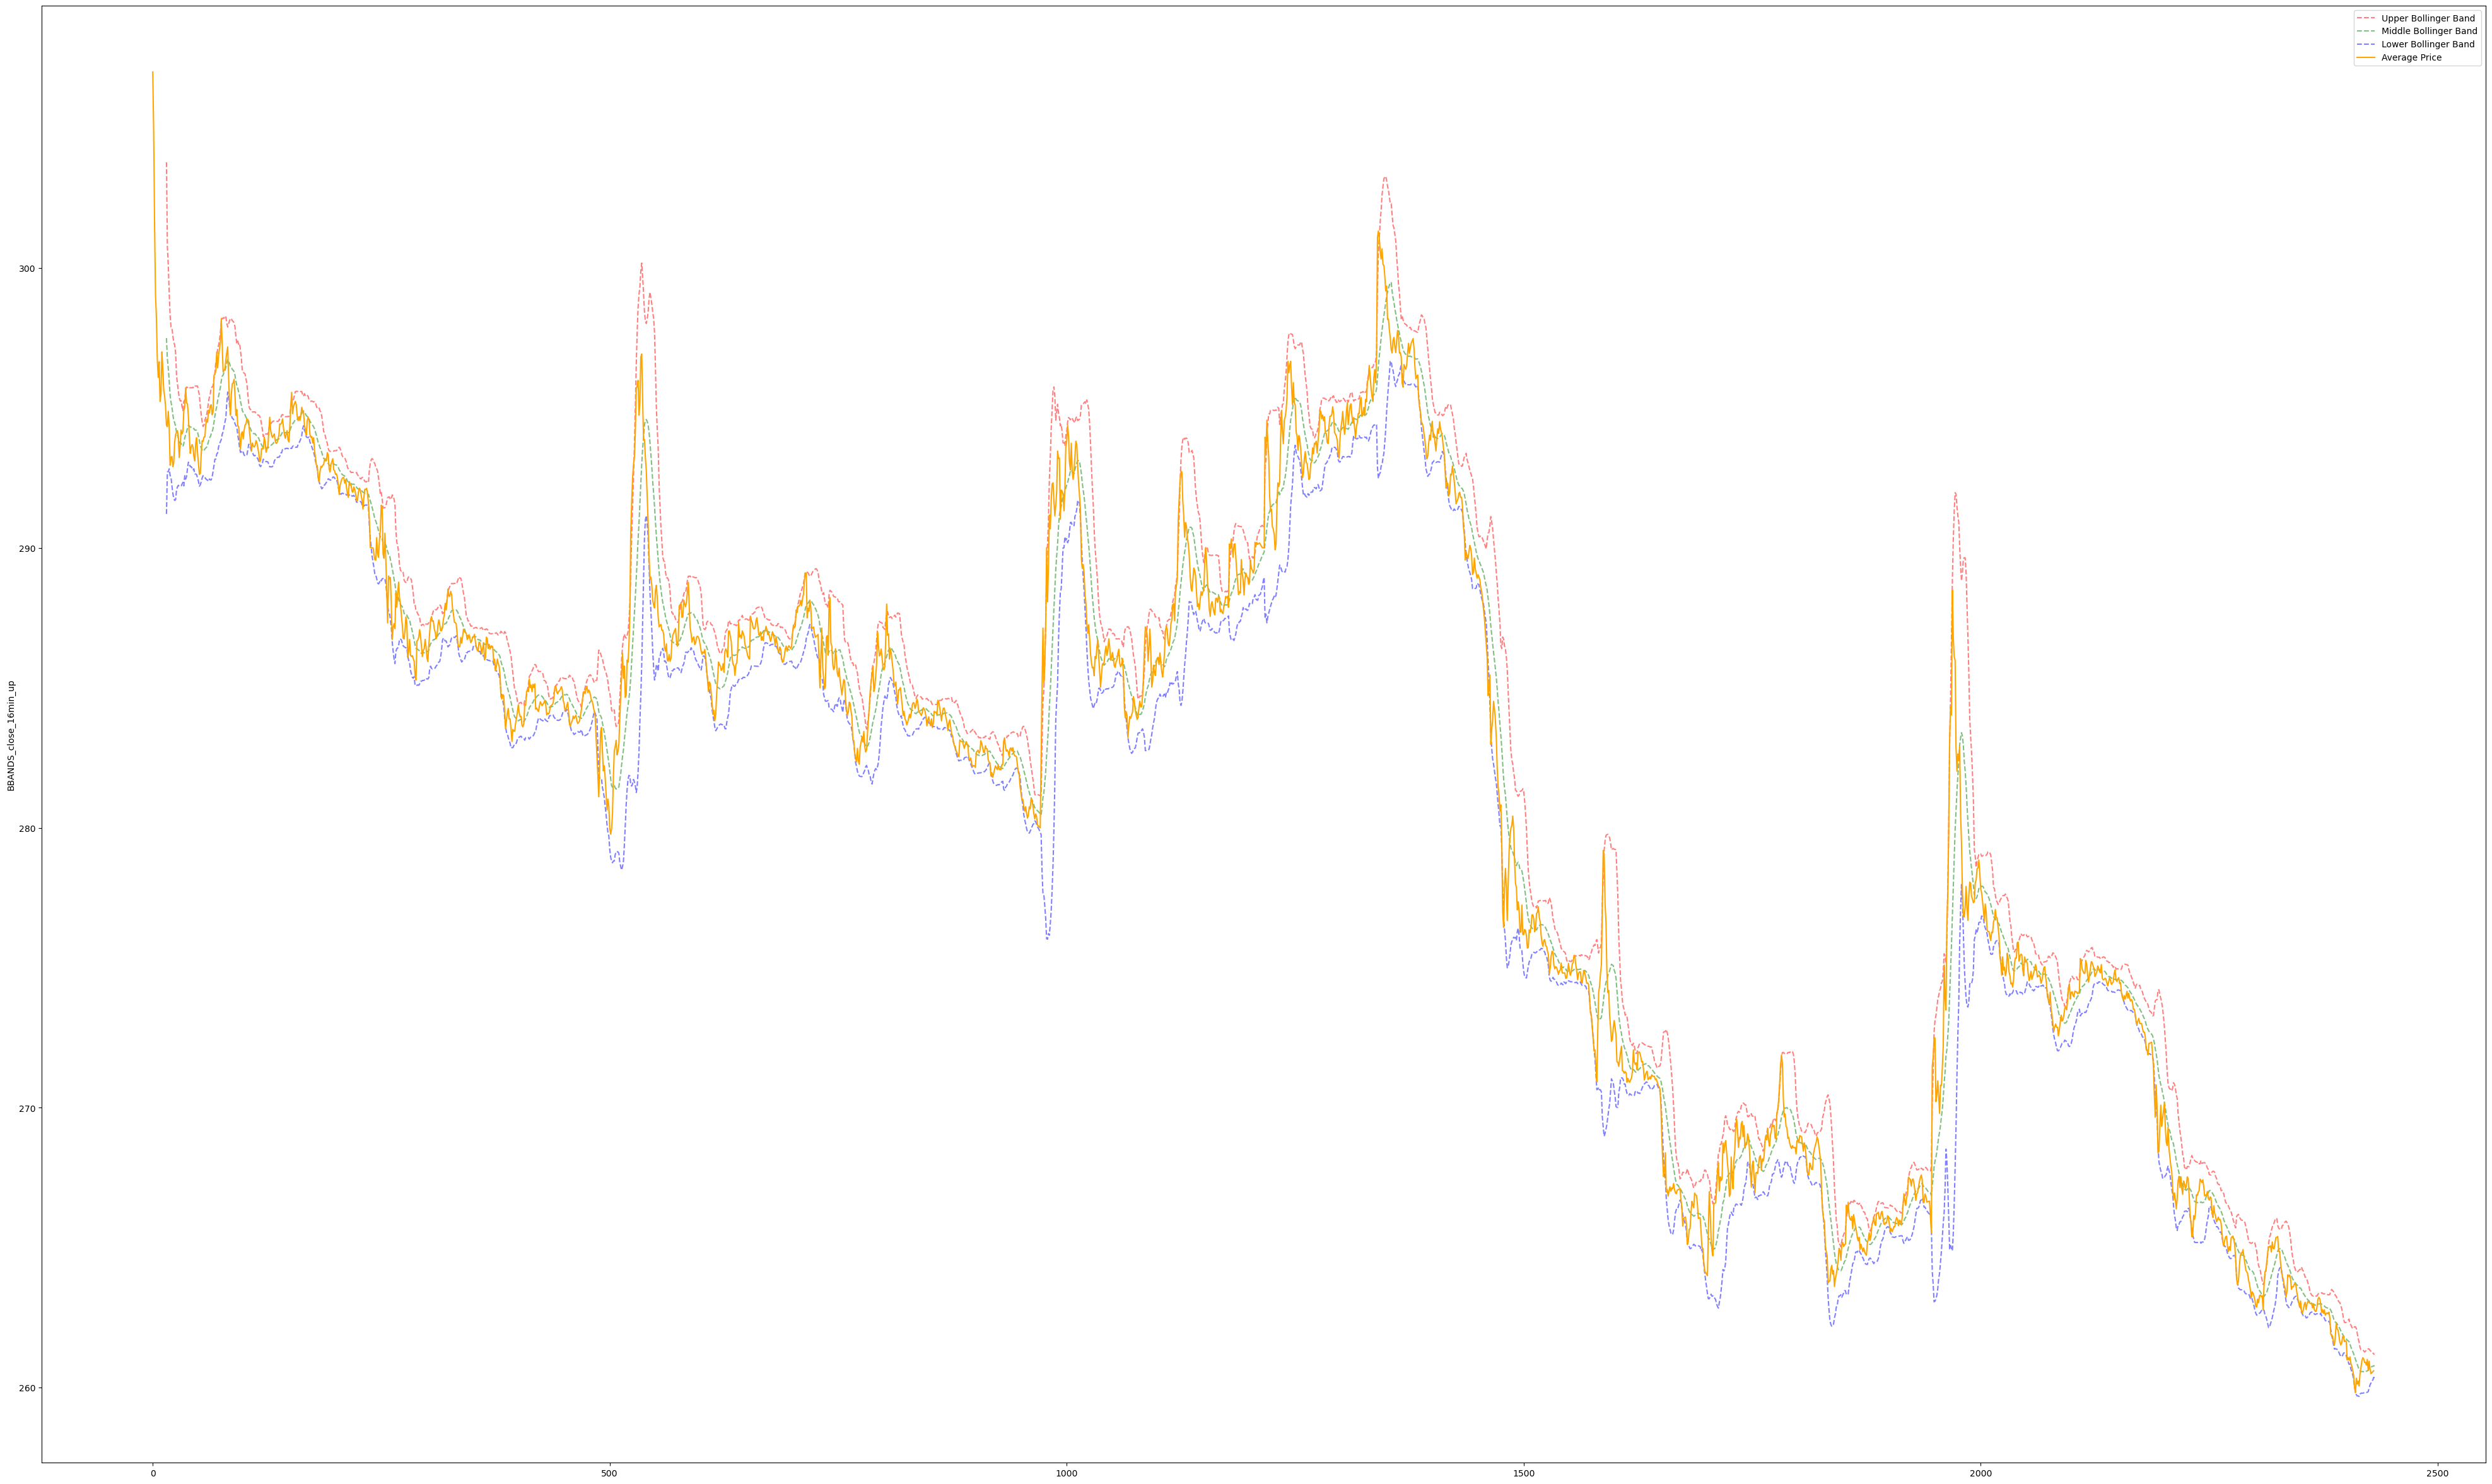

In [107]:
plt.figure(figsize=(50, 30))

sns.lineplot(data=df['BBANDS_close_16min_up'], label='Upper Bollinger Band',linestyle='--', color='r', alpha=0.5)
sns.lineplot(data=df['BBANDS_close_16min_mid'], label='Middle Bollinger Band', linestyle='--', color='g', alpha=0.5)
sns.lineplot(data=df['BBANDS_close_16min_low'], label='Lower Bollinger Band', linestyle='--',color='b', alpha=0.5)
sns.lineplot(data=df['Avg'], label='Average Price', color='orange')

plt.legend()
plt.show()

Add Targets

In [108]:
df['Target_Close_1min'] = target(df,'Close', 1)
df['Target_Avg_1min'] = target(df, 'Avg', 1)

Add Features on Stock

In [109]:
df_stock['STOCK_log_ret_close_1min'] = log_Return(df_stock, 'Close', 1)
df_stock['BBANDS_close_16min_up'], df_stock['BBANDS_close_16min_mid'], df_stock['BBANDS_close_16min_low'] = BBands(df_stock, 'Close', 16)
df_stock['STOCK_MACD_close_F12S26S9'] = MACD(df_stock, 'Close', fastPeriod=12, slowPeriod=26, signalPeriod=9)
df_stock['STOCK_RSI_close_12min'] = RSI(df_stock, 'Close', period=12)
df_stock['STOCK_SAR'] = SAR(df_stock, 0.02, 0.2)

df_stock['STOCK_BB_hit_wall'] = BB_hit_wall(df_stock)


Merging

In [110]:
df_stock = df_stock[['STOCK_log_ret_close_1min', 'STOCK_MACD_close_F12S26S9',
       'STOCK_RSI_close_12min', 'STOCK_SAR', 'STOCK_BB_hit_wall']]

result = pd.merge(df, df_stock, how='left', left_index= True, right_index=True)

Cleaning and saving

In [111]:
print('Number of rows before cleaning: %d'%result.shape[0])

result = result.dropna()

result.index = result['Timestamp']
result = result.drop(['Timestamp'], axis=1)

print('Number of rows after cleaning: %d'%result.shape[0])

result.to_csv(PATH_WRITE)

Number of rows before cleaning: 2432
Number of rows after cleaning: 2347
